pygame 2.0.1 (SDL 2.0.14, Python 3.8.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


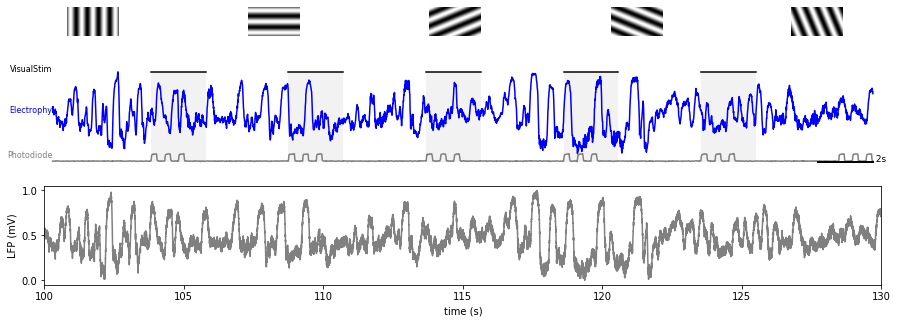

In [1]:
# general modules
import pynwb, os, sys
import numpy as np
import matplotlib.pylab as plt

# custom physion module
sys.path.append('..')
from physion.dataviz.show_data import MultimodalData

filename = '/home/yann/DATA/Electrophy/2021_05_03/2021_05_03-16-08-12.nwb'
#filename='/home/yann/DATA/Electrophy/2021_05_03/2021_05_03-14-46-51.nwb'
#filename = '/home/yann/DATA/Electrophy/2021_05_03/2021_05_03-14-38-11.nwb'

data = MultimodalData(filename)

tlim = [100, 130]
fig, [ax1, ax2] = plt.subplots(2,1, figsize=(15,4))
_ = data.plot(tlim, 
              settings={'Photodiode':dict(fig_fraction=.1, subsampling=10, color='grey'),
                        'Electrophy':dict(fig_fraction=1, subsampling=100, color='b'),
                        'VisualStim':dict(fig_fraction=0, color='black', size=0.1)},                    
              Tbar=2, ax=ax1)
data.add_Electrophy(tlim, ax2)
ax2.set_xlim(tlim)
ax2.set_xlabel('time (s)');ax2.set_ylabel('LFP (mV)');

# Band-pass filtering

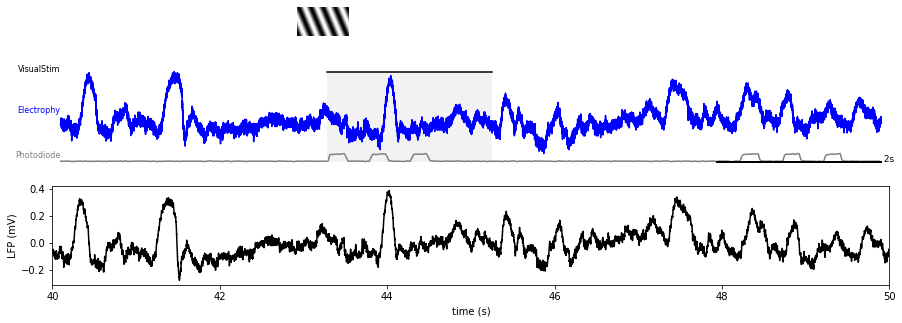

In [4]:
from scipy import signal

def butter_bandpass(lowcut, highcut, Facq, order=5):
    nyq = 0.5 * Facq
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, Facq, order=5):
    b, a = butter_bandpass(lowcut, highcut, Facq, order=order)
    y = signal.lfilter(b, a, data)
    return y

setattr(data, 'fLFP',
        butter_bandpass_filter(data.nwbfile.acquisition['Electrophysiological-Signal'].data[:],
                               0.1, 300., data.nwbfile.acquisition['Electrophysiological-Signal'].rate, order=2))

tlim = [40, 50]
fig, [ax1, ax2] = plt.subplots(2,1, figsize=(15,4))
_ = data.plot(tlim, 
              settings={'Photodiode':dict(fig_fraction=.1, subsampling=10, color='grey'),
                        'Electrophy':dict(fig_fraction=1, subsampling=1, color='b'),
                        'VisualStim':dict(fig_fraction=0, color='black', size=0.1)},                    
              Tbar=2, ax=ax1)
        
subsampling = 1
i1, i2 = convert_times_to_indices(*tlim, data.nwbfile.acquisition['Electrophysiological-Signal'])
t = convert_index_to_time(range(i1,i2), data.nwbfile.acquisition['Electrophysiological-Signal'])[::subsampling]
y = data.fLFP[i1:i2][::subsampling]
ax2.plot(t, y, 'k-')
ax2.set_xlim(tlim)
ax2.set_xlabel('time (s)');ax2.set_ylabel('LFP (mV)');

In [5]:
import numpy as np
from scipy import signal
from scipy.ndimage.filters import gaussian_filter1d


##############################################
########### Wavelet Transform ################
##############################################

def my_cwt(data, frequencies, dt, w0=6.):
    """
    wavelet transform with normalization to catch the amplitude of a sinusoid
    """
    output = np.zeros([len(frequencies), len(data)], dtype=np.complex)

    for ind, freq in enumerate(frequencies):
        # get the wavelet for that frequency (un-normalized)
        wavelet_data = np.conj(get_Morlet_of_right_size(freq, dt, w0=w0))
        # compute the sliding mean
        sliding_mean = signal.convolve(data,
                                       np.ones(len(wavelet_data))/len(wavelet_data),
                                       mode='same')
        # the final convolution (including wavelet normalization)
        wavelet_data_norm = norm_constant_th(freq, dt, w0=w0)
        output[ind, :] = signal.convolve(data-sliding_mean+0.*1j,
                                         wavelet_data,
                                         mode='same')/wavelet_data_norm
    return output

### MORLET WAVELET, definition, properties and normalization
def Morlet_Wavelet(t, f, w0=6.):
    x = 2.*np.pi*f*t
    output = np.exp(1j * x)
    output *= np.exp(-0.5 * ((x/w0) ** 2)) # (Normalization comes later)
    return output

def Morlet_Wavelet_Decay(f, w0=6.):
    return 2 ** .5 * (w0/(np.pi*f))

def from_fourier_to_morlet(freq):
    x = np.linspace(0.1/freq, 2.*freq, 1e3)
    return x[np.argmin((x-freq*(1-np.exp(-freq*x)))**2)]
    
def get_Morlet_of_right_size(f, dt, w0=6., with_t=False):
    Tmax = Morlet_Wavelet_Decay(f, w0=w0)
    t = np.arange(-int(Tmax/dt), int(Tmax/dt)+1)*dt
    if with_t:
        return t, Morlet_Wavelet(t, f, w0=w0)
    else:
        return Morlet_Wavelet(t, f, w0=w0)

def norm_constant_th(freq, dt, w0=6.):
    # from theoretical calculus:
    n = (w0/2./np.sqrt(2.*np.pi)/freq)*(1.+np.exp(-w0**2/2))
    return n/dt

##################################################
########### Processing of the LFP ################
##################################################

def gaussian_smoothing(Signal, idt_sbsmpl=10.):
    """Gaussian smoothing of the data"""
    return gaussian_filter1d(Signal, idt_sbsmpl)

def preprocess_LFP(data,
                   freqs = np.linspace(20, 100, 10),
                   new_dt = 5e-3, # desired subsampling freq.
                   Vext_key='Extra',
                   gain=1.,
                   smoothing=40e-3,
                   percentile_for_p0=0.01,                   
                   pLFP_unit='$\mu$V'):
    """
    performs continuous wavelet transform and smooth the time-varying high-gamma freq power
    """
    
    # performing wavelet transform
    W = my_cwt(gain*data.nwbfile.acquisition['Electrophysiological-Signal'].data[:], freqs,
               1./data.nwbfile.acquisition['Electrophysiological-Signal'].rate) 
    pLFP_freqs = freqs # keeping track of the frequency used

    # taking the mean power over the frequency content considered
    W2 = np.abs(W).mean(axis=0)
    isubsmpl = int(new_dt*data.nwbfile.acquisition['Electrophysiological-Signal'].rate)
    
    # then smoothing and subsampling
    pLFP = gaussian_smoothing(np.reshape(W2[:int(len(W2)/isubsmpl)*isubsmpl],
                              (int(len(W2)/isubsmpl),isubsmpl)).mean(axis=1),
                              int(smoothing/new_dt)).flatten()
    new_t = np.arange(len(pLFP))*new_dt
    # find p0
    p0 = np.percentile(pLFP, percentile_for_p0)
    
    setattr(data, 'pLFP', pLFP)
    setattr(data, 't_pLFP', new_t)
    #setattr(data, 'pLFP', pLFP)

In [6]:
preprocess_LFP(data)

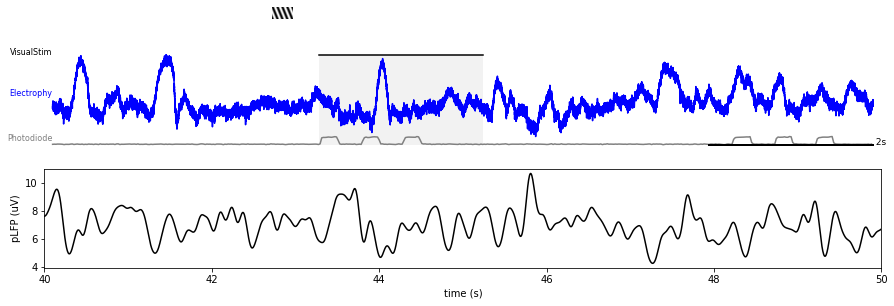

In [7]:
#tlim = [100, 120]

fig, [ax1, ax2] = plt.subplots(2,1, figsize=(15,4))

_ = data.plot(tlim, 
              settings={'Photodiode':dict(fig_fraction=.1, subsampling=10, color='grey'),
                        'Electrophy':dict(fig_fraction=1, subsampling=1, color='b'),
                        'VisualStim':dict(fig_fraction=0, color='black', size=0.04)},                    
              Tbar=2, ax=ax1)

cond = (data.t_pLFP>tlim[0]) & (data.t_pLFP<tlim[1])
ax2.plot(data.t_pLFP[cond], 1e3*data.pLFP[cond], 'k')
ax2.set_xlim(tlim)
ax2.set_xlabel('time (s)');ax2.set_ylabel('pLFP (uV)');